**Library Imports**

In [3]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

**Data Loading**

In [5]:
# Load the new dataset and inspect the first few rows
data = pd.read_csv('data/sessions.csv')

# Display the first few rows
data

,user_id,session_start_timestamp
0,860,1690601731230600
1,5499,1691834041064526
2,10720,1691500832236053
3,12875,1690948104259080
4,14616,1691800553553408
...,...,...
170922,30575,1692385169230647
170923,32307,1690680952228800
170924,35987,1692096068268278
170925,36429,1691287370895001


**Data Exploration and Overview**

In [7]:
pd.set_option('display.width', 1000)  # expand display
pd.set_option('display.max_columns', None)  # show all columns

# For data
print("##################### df_level_start ############")
print("##################### Shape #####################")
print(data.shape)
print("##################### Types #####################")
print(data.dtypes)
print("##################### Head #####################")
print(data.head())
print("##################### Tail #####################")
print(data.tail())
print("##################### NA #####################")
print(data.isnull().sum())

##################### df_level_start ############
##################### Shape #####################
(170927, 2)
##################### Types #####################
user_id                    int64
session_start_timestamp    int64
dtype: object
##################### Head #####################
   user_id  session_start_timestamp
0      860         1690601731230600
1     5499         1691834041064526
2    10720         1691500832236053
3    12875         1690948104259080
4    14616         1691800553553408
##################### Tail #####################
        user_id  session_start_timestamp
170922    30575         1692385169230647
170923    32307         1690680952228800
170924    35987         1692096068268278
170925    36429         1691287370895001
170926    37386         1692393453874611
##################### NA #####################
user_id                    0
session_start_timestamp    0
dtype: int64


In [8]:
# Time adjustment for accuracy and error prevention in record review
data['date'] = pd.to_datetime(data['session_start_timestamp'], unit='us').dt.date
data.drop(columns=['session_start_timestamp'], inplace=True)
data

,user_id,date
0,860,2023-07-29
1,5499,2023-08-12
2,10720,2023-08-08
3,12875,2023-08-02
4,14616,2023-08-12
...,...,...
170922,30575,2023-08-18
170923,32307,2023-07-30
170924,35987,2023-08-15
170925,36429,2023-08-06


In [9]:
# There is no more 1 session in a day for each user
duplicates = data[data.duplicated(subset=['user_id', 'date'], keep=False)]
duplicates.shape

(0, 2)

In [10]:
# Calculate the daily unique active user count
daily_active_users = data.groupby('date')['user_id'].nunique().reset_index(name='daily_active_users')
daily_active_users.head()

,date,daily_active_users
0,2023-07-27,9537
1,2023-07-28,10587
2,2023-07-29,10534
3,2023-07-30,10640
4,2023-07-31,8320


In [11]:
daily_active_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   date                27 non-null     object
 1   daily_active_users  27 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 564.0+ bytes


In [12]:
# Identify new users by tagging each user's first occurrence by date
data['is_new_user'] = data.sort_values(by='date').duplicated(subset=['user_id'], keep='first').apply(lambda x: not x)

# Calculate the daily count of new users
daily_new_users = data[data['is_new_user']].groupby('date')['user_id'].nunique().reset_index()
daily_new_users.columns = ['date', 'new_users']

# Combine daily active users and new users into one dataset
final_data = pd.merge(daily_active_users, daily_new_users, on='date')

# Display the data
final_data.head()

,date,daily_active_users,new_users
0,2023-07-27,9537,9537
1,2023-07-28,10587,5484
2,2023-07-29,10534,4059
3,2023-07-30,10640,3332
4,2023-07-31,8320,518


In [13]:
final_data

,date,daily_active_users,new_users
0,2023-07-27,9537,9537
1,2023-07-28,10587,5484
2,2023-07-29,10534,4059
3,2023-07-30,10640,3332
4,2023-07-31,8320,518
5,2023-08-01,7512,381
6,2023-08-02,6993,317
7,2023-08-03,6681,273
8,2023-08-04,6512,248
9,2023-08-05,6100,225


**Graph of Daily Active Users and Daily New Users**

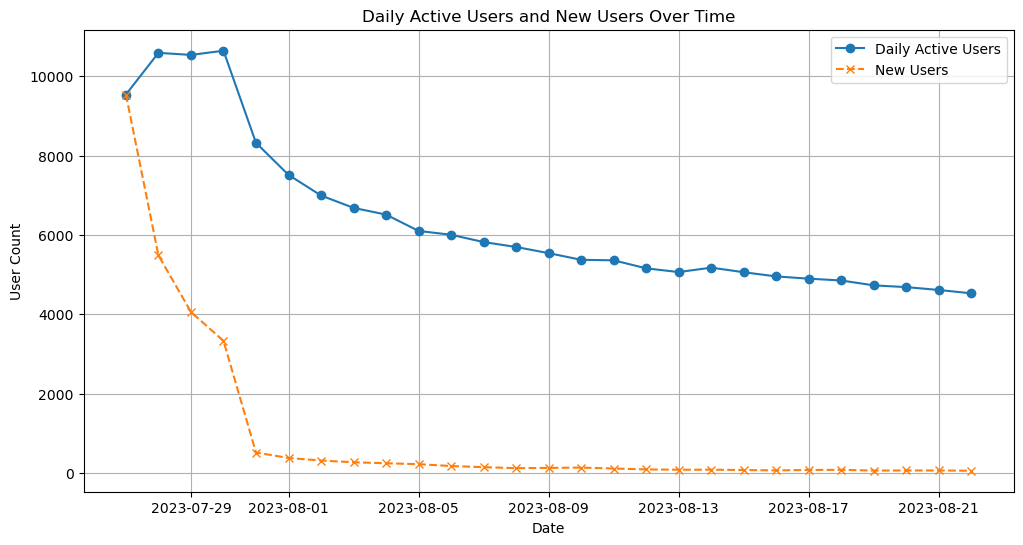

In [15]:
# Line plot showing daily active users and new users
plt.figure(figsize=(12, 6))
plt.plot(final_data['date'], final_data['daily_active_users'], label='Daily Active Users', marker='o')
plt.plot(final_data['date'], final_data['new_users'], label='New Users', linestyle='--', marker='x')
plt.title("Daily Active Users and New Users Over Time")
plt.xlabel("Date")
plt.ylabel("User Count")
plt.legend()
plt.grid(True)
plt.show()

**ADF Test**

In [17]:
# Apply the ADF test to check for stationarity by examining the p-value
result_dau = adfuller(final_data['daily_active_users'])
adf_statistic_dau = result_dau[0]
p_value_dau = result_dau[1]

adf_statistic_dau, p_value_dau

(-3.890562585964533, 0.002105409571668254)

**ACF and PACF Graphs**

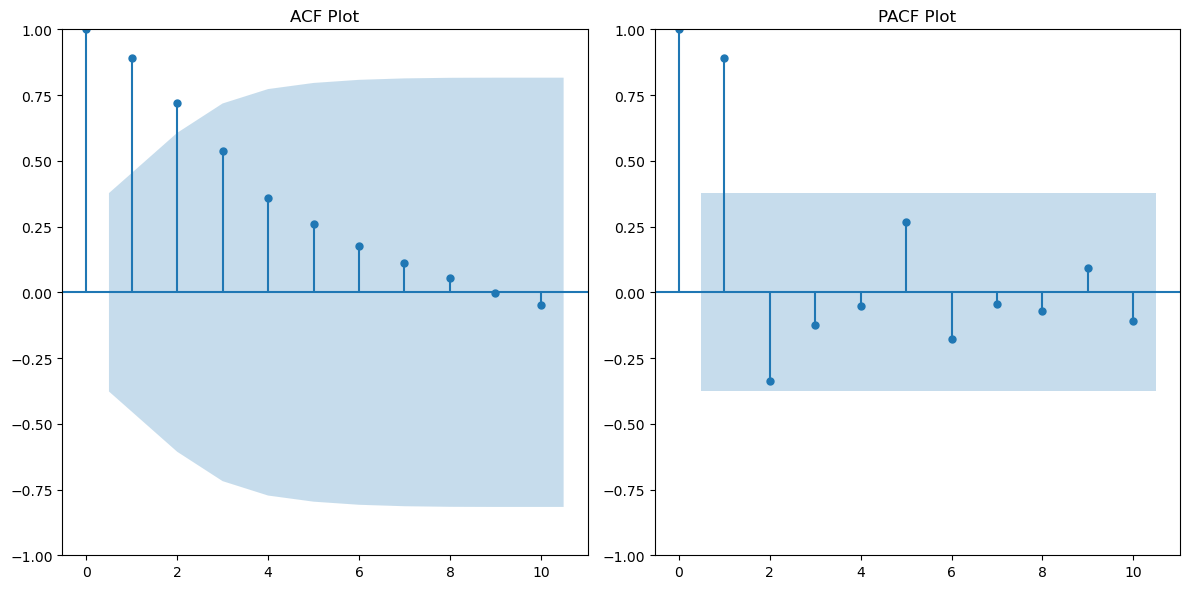

In [19]:
# Plot ACF and PACF graphs
plt.figure(figsize=(12, 6))

# ACF plot (to determine q value)
plt.subplot(1, 2, 1)
plot_acf(final_data['daily_active_users'], ax=plt.gca(), lags=10)
plt.title("ACF Plot")

# PACF plot (to determine p value)
plt.subplot(1, 2, 2)
plot_pacf(final_data['daily_active_users'], ax=plt.gca(), lags=10, method='ywm')
plt.title("PACF Plot")

plt.tight_layout()
plt.show()

**MODEL STEPS**

**ARIMAX model for DAU**

Create train and test datas for ARIMAX model

In [23]:
# Set the last 5 days as the test set and the rest as the training set
exog_train_dau = final_data[['new_users']][:-4] 
exog_test_dau = final_data[['new_users']][-5:]   
train_data_dau = final_data['daily_active_users'][:-4]
test_data_dau = final_data['daily_active_users'][-5:]

Finding best params for ARIMAX

In [25]:
# Try different (p, d, q) combinations
p_values_dau_try = [0, 1, 2]
d_values_dau_try = [0, 1]
q_values_dau_try = [0, 1, 2]

best_order_dau_try = None
best_rmse_dau_try = float("inf")

# Loop through all combinations
for p, d, q in product(p_values_dau_try, d_values_dau_try, q_values_dau_try):
    try:
        # Define and fit the SARIMAX model
        model_dau_try = SARIMAX(train_data_dau, order=(p, d, q), exog=exog_train_dau)
        model_fit_dau_try = model_dau_try.fit(disp=False)
        
        # Forecast on the test set
        forecast = model_fit_dau_try.get_forecast(steps=len(test_data_dau), exog=exog_test_dau)
        forecast_mean_dau_try = forecast.predicted_mean
        
        # Calculate RMSE
        rmse_dau_try = np.sqrt(mean_squared_error(test_data_dau, forecast_mean_dau_try))
        
        # Save the best RMSE and parameters
        if rmse_dau_try < best_rmse_dau_try:
            best_rmse_dau_try = rmse_dau_try
            best_order_dau_try = (p, d, q)
        
        print(f"Order: ({p}, {d}, {q}) - RMSE: {rmse_dau_try:.4f}")
    
    except Exception as e:
        print(f"Order: ({p}, {d}, {q}) - Model failed to converge")

print("\nBest parameters:")
print(f"Order: {best_order_dau_try} - Lowest RMSE: {best_rmse_dau_try:.4f}")


Order: (0, 0, 0) - RMSE: 4569.8367
Order: (0, 0, 1) - RMSE: 4211.8865
Order: (0, 0, 2) - RMSE: 3948.5338
Order: (0, 1, 0) - RMSE: 201.1136
Order: (0, 1, 1) - RMSE: 189.6105


C:\Users\Baran\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Baran\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order: (0, 1, 2) - RMSE: 326.6786
Order: (1, 0, 0) - RMSE: 143.7467
Order: (1, 0, 1) - RMSE: 108.8403
Order: (1, 0, 2) - RMSE: 419.1021
Order: (1, 1, 0) - RMSE: 154.2499
Order: (1, 1, 1) - RMSE: 48.1138
Order: (1, 1, 2) - RMSE: 317.4254
Order: (2, 0, 0) - RMSE: 30.6655


C:\Users\Baran\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Baran\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order: (2, 0, 1) - RMSE: 30.7286
Order: (2, 0, 2) - RMSE: 246.2751
Order: (2, 1, 0) - RMSE: 165.7738


C:\Users\Baran\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Baran\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Baran\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Baran\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Baran\anaconda3\Lib\site-packages\statsmodels\tsa\states

Order: (2, 1, 1) - RMSE: 154.2511
Order: (2, 1, 2) - RMSE: 5193.7847

Best parameters:
Order: (2, 0, 0) - Lowest RMSE: 30.6655


C:\Users\Baran\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Set up and train ARIMAX with best params

In [27]:
# Set up and train the ARIMAX model
model_dau = SARIMAX(train_data_dau, order=(2, 0, 0), exog=exog_train_dau)
model_fit_dau = model_dau.fit()

# Forecast over the test set period (5-day forecast)
forecast_dau = model_fit_dau.get_forecast(steps=len(test_data_dau), exog=exog_test_dau)
forecast_mean_dau = forecast_dau.predicted_mean

# Calculate error metrics
mae_dau = mean_absolute_error(test_data_dau, forecast_mean_dau)
mse_dau = mean_squared_error(test_data_dau, forecast_mean_dau)
rmse_dau = np.sqrt(mse_dau)

# Calculate the average daily active users
avg_daily_active_users_dau = train_data_dau.mean()

# Calculate the error percentage
error_percentage_dau = (rmse_dau / avg_daily_active_users_dau) * 100

# Print the results
print("Model Error Metrics:")
print(f"Mean Absolute Error (MAE): {mae_dau}")
print(f"Mean Squared Error (MSE): {mse_dau}")
print(f"Root Mean Squared Error (RMSE): {rmse_dau}")
print(f"Error Percentage (%): {error_percentage_dau:.2f}%")


Model Error Metrics:
Mean Absolute Error (MAE): 23.65305803127303
Mean Squared Error (MSE): 940.3736462319903
Root Mean Squared Error (RMSE): 30.665512326259776
Error Percentage (%): 0.46%


Graph of ARIMAX Predictions 

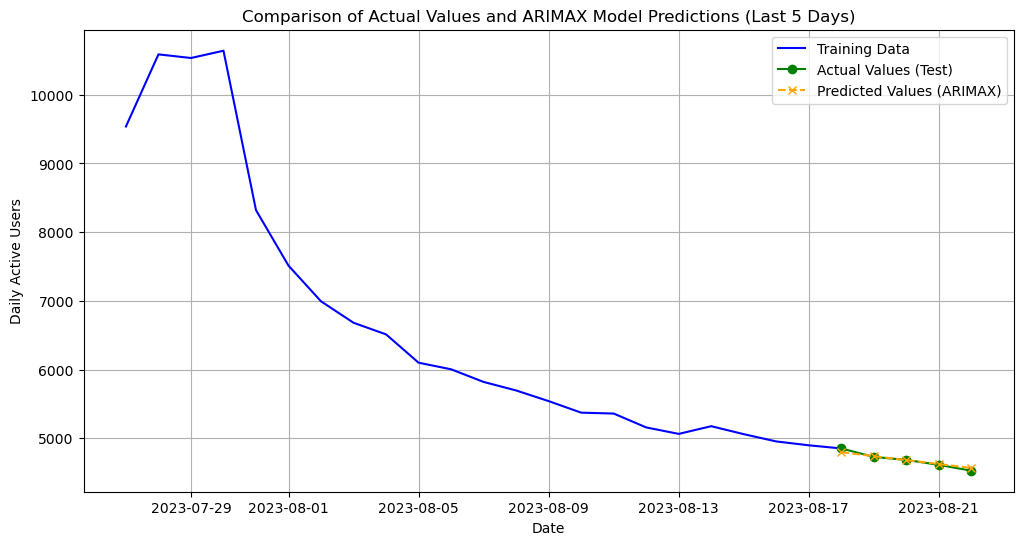

In [29]:
label_train = final_data["date"][:-4]
label_test_and_forecast = final_data["date"][-5:]

# Set the date index for predicted values to align with the test data
forecast_series_dau = pd.Series(forecast_mean_dau.values, index=test_data_dau.index)

# Plotting
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(label_train, train_data_dau, label='Training Data', color='blue')

# Plot test data (actual values)
plt.plot(label_test_and_forecast, test_data_dau, label='Actual Values (Test)', color='green', marker='o')

# Plot predicted values (ARIMAX model)
plt.plot(label_test_and_forecast, forecast_series_dau, label='Predicted Values (ARIMAX)', color='orange', linestyle='--', marker='x')

# Plot title and labels
plt.title("Comparison of Actual Values and ARIMAX Model Predictions (Last 5 Days)")
plt.xlabel("Date")
plt.ylabel("Daily Active Users")
plt.legend()
plt.grid(True)
plt.show()


**ARIMA Model(Finding the daily new user count for the next 30 days)** 

ADF TEST

In [32]:
# Apply the ADF test to check the p-value for stationarity (for ARIMA)
result_new_users = adfuller(final_data['new_users'])
adf_statistic_new_users = result_new_users[0]
p_value_new_users = result_new_users[1]

adf_statistic_new_users, p_value_new_users

(-2.779599694845894, 0.06124741151567241)

ACF and PACF Graphs

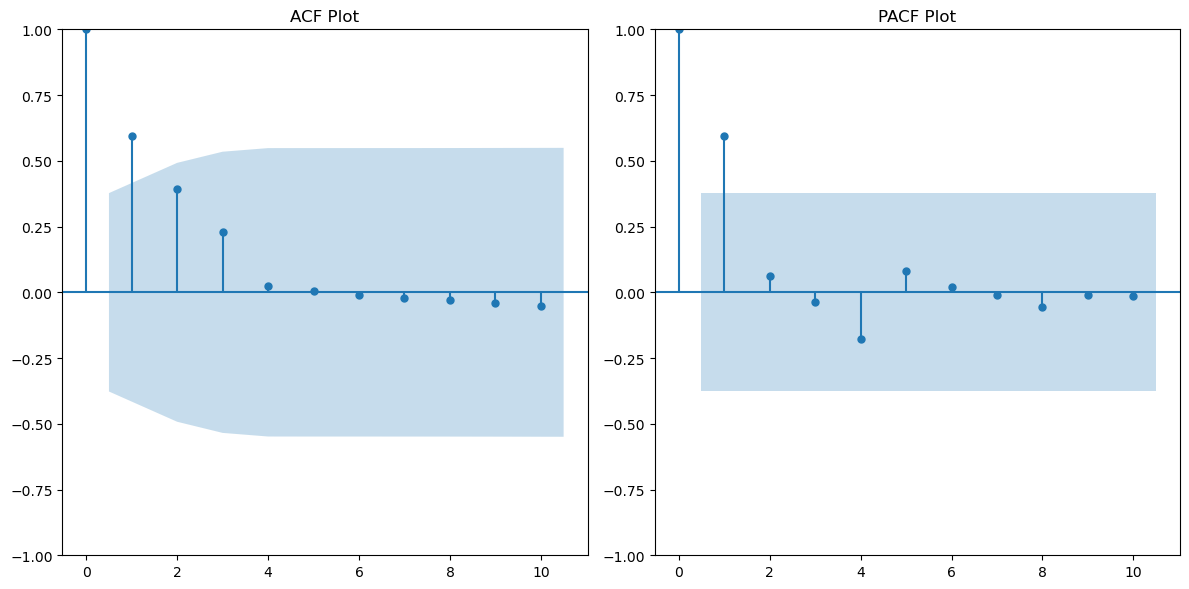

In [34]:
# Plot ACF and PACF graphs
plt.figure(figsize=(12, 6))

# ACF plot (to determine the q value)
plt.subplot(1, 2, 1)
plot_acf(final_data['new_users'], ax=plt.gca(), lags=10)
plt.title("ACF Plot")

# PACF plot (to determine the p value)
plt.subplot(1, 2, 2)
plot_pacf(final_data['new_users'], ax=plt.gca(), lags=10, method='ywm')
plt.title("PACF Plot")

plt.tight_layout()
plt.show()

Create train and test datas for ARIMA model

In [36]:
# Set the last 5 days as the test set, and the rest as the training set
train_data_new_users = final_data['new_users'][:-4]
test_data_new_users = final_data['new_users'][-5:]

Finding best params for ARIMA

In [38]:
# Try different (p, d, q) combinations
p_values_new_users_try = [0, 1, 2]
d_values_new_users_try = [0, 1]
q_values_new_users_try = [0, 1, 2]

best_order_new_users_try = None
best_rmse_new_users_try = float("inf")

# Loop through all combinations
for p, d, q in product(p_values_new_users_try, d_values_new_users_try, q_values_new_users_try):
    try:
        # Define and fit the ARIMA model
        model_new_users_try = ARIMA(train_data_new_users, order=(p, d, q))
        model_fit_new_users_try = model_new_users_try.fit()
        
        # Forecast on the test set
        forecast_new_users_try = model_fit_new_users_try.forecast(steps=len(test_data_new_users))
        
        # Calculate RMSE
        rmse_new_users_try = np.sqrt(mean_squared_error(test_data_new_users, forecast_new_users_try))
        
        # Save the best RMSE and parameters
        if rmse_new_users_try < best_rmse_new_users_try:
            best_rmse_new_users_try = rmse_new_users_try
            best_order_new_users_try = (p, d, q)
        
        print(f"Order: ({p}, {d}, {q}) - RMSE: {rmse_new_users_try:.4f}")
    
    except Exception as e:
        print(f"Order: ({p}, {d}, {q}) - Model failed to converge")

print("\nBest parameters:")
print(f"Order: {best_order_new_users_try} - Lowest RMSE: {best_rmse_new_users_try:.4f}")

Order: (0, 0, 0) - RMSE: 1053.3120
Order: (0, 0, 1) - RMSE: 1057.8631
Order: (0, 0, 2) - RMSE: 1155.2424
Order: (0, 1, 0) - RMSE: 16.2481
Order: (0, 1, 1) - RMSE: 43.0170


C:\Users\Baran\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Baran\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order: (0, 1, 2) - RMSE: 30.4857
Order: (1, 0, 0) - RMSE: 100.0255
Order: (1, 0, 1) - RMSE: 158.0063


C:\Users\Baran\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Baran\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Baran\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Baran\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order: (1, 0, 2) - RMSE: 112.5934
Order: (1, 1, 0) - RMSE: 15.7364
Order: (1, 1, 1) - RMSE: 10.1005
Order: (1, 1, 2) - RMSE: 94.5666
Order: (2, 0, 0) - RMSE: 209.7470
Order: (2, 0, 1) - RMSE: 228.1459
Order: (2, 0, 2) - RMSE: 329.7388
Order: (2, 1, 0) - RMSE: 15.6505


C:\Users\Baran\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Baran\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Baran\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Order: (2, 1, 1) - RMSE: 12.2909
Order: (2, 1, 2) - RMSE: 68.0176

Best parameters:
Order: (1, 1, 1) - Lowest RMSE: 10.1005


C:\Users\Baran\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Baran\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Baran\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Set up and train ARIMA with best params

In [40]:
# Set up and train the ARIMA(1,1,1) model
model_new_users = ARIMA(train_data_new_users, order=(1, 1, 1))
model_fit_new_users = model_new_users.fit()

# Forecast over the test set period
forecast_new_users = model_fit_new_users.forecast(steps=len(test_data_new_users))

# Calculate error metrics
mae_new_users = mean_absolute_error(test_data_new_users, forecast_new_users)
mse_new_users = mean_squared_error(test_data_new_users, forecast_new_users)
rmse_new_users = np.sqrt(mse_new_users)
error_percentage_new_users = (mae_new_users / np.mean(test_data_new_users)) * 100

# Print the results
print("Model Error Metrics:")
print(f"Mean Absolute Error (MAE): {mae_new_users}")
print(f"Mean Squared Error (MSE): {mse_new_users}")
print(f"Root Mean Squared Error (RMSE): {rmse_new_users}")
print(f"Error Percentage (%): {error_percentage_new_users:.2f}%")

Model Error Metrics:
Mean Absolute Error (MAE): 9.218435088077007
Mean Squared Error (MSE): 102.020286279692
Root Mean Squared Error (RMSE): 10.100509208930607
Error Percentage (%): 13.64%


C:\Users\Baran\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Baran\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Graph of ARIMA Predictions

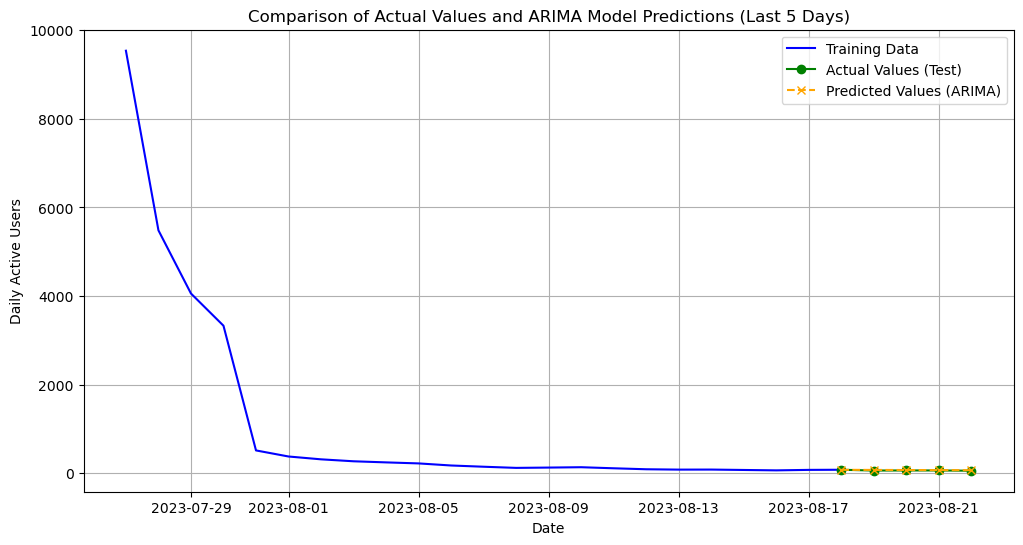

In [42]:
label_train = final_data["date"][:-4]
label_test_and_forecast = final_data["date"][-5:]

# Set the date index for predicted values to align with the test data
forecast_new_users = pd.Series(forecast_new_users.values, index=test_data_new_users.index)

# Plotting
plt.figure(figsize=(12, 6))

# Plot training data
plt.plot(label_train, train_data_new_users, label='Training Data', color='blue')

# Plot test data (actual values)
plt.plot(label_test_and_forecast, test_data_new_users, label='Actual Values (Test)', color='green', marker='o')

# Plot predicted values (ARIMA model)
plt.plot(label_test_and_forecast, forecast_new_users, label='Predicted Values (ARIMA)', color='orange', linestyle='--', marker='x')

# Plot title and labels
plt.title("Comparison of Actual Values and ARIMA Model Predictions (Last 5 Days)")
plt.xlabel("Date")
plt.ylabel("Daily Active Users")
plt.legend()
plt.grid(True)
plt.show()

Visualization of the Performance Of ARIMAX (For DAU) And ARIMA (For New Users) Models

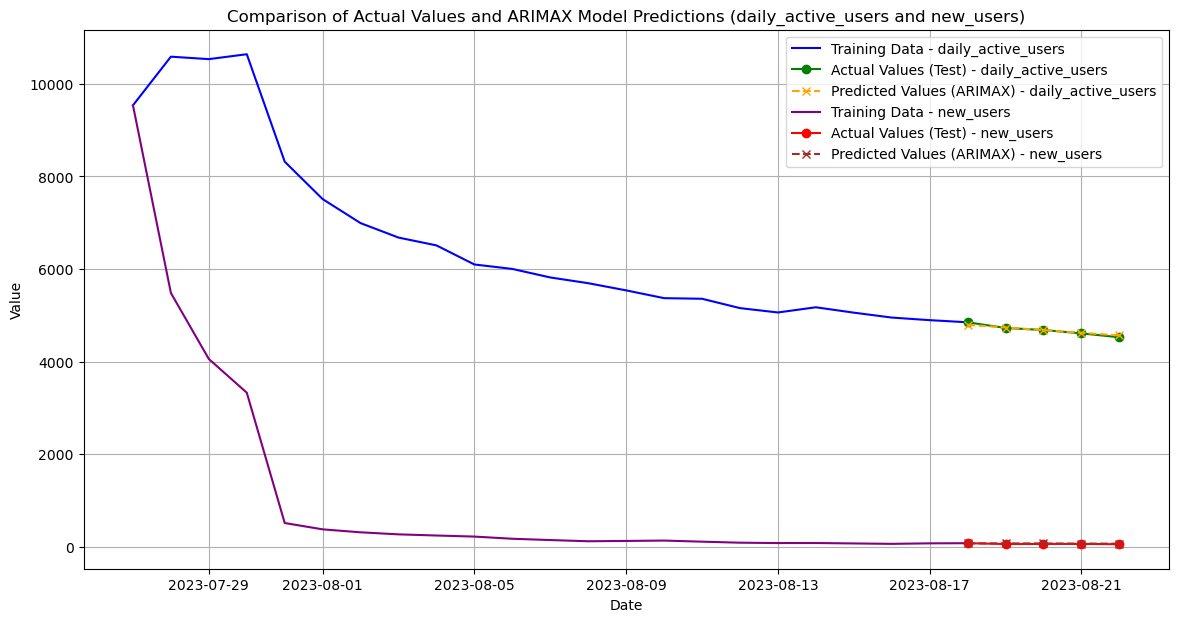

In [44]:
label_train = final_data["date"][:-4]
label_test_and_forecast = final_data["date"][-5:]

# Plotting
plt.figure(figsize=(14, 7))

# Plot training data for daily_active_users
plt.plot(label_train, train_data_dau, label='Training Data - daily_active_users', color='blue')

# Plot test data (actual values) for daily_active_users
plt.plot(label_test_and_forecast, test_data_dau, label='Actual Values (Test) - daily_active_users', color='green', marker='o')

# Plot predicted values for daily_active_users
plt.plot(label_test_and_forecast, forecast_series_dau, 
         label='Predicted Values (ARIMAX) - daily_active_users', color='orange', linestyle='--', marker='x')

# Plot training data for new_users
plt.plot(label_train, train_data_new_users, label='Training Data - new_users', color='purple')

# Plot test data (actual values) for new_users
plt.plot(label_test_and_forecast, test_data_new_users, label='Actual Values (Test) - new_users', color='red', marker='o')

# Plot predicted values for new_users
plt.plot(label_test_and_forecast, forecast_new_users, 
         label='Predicted Values (ARIMAX) - new_users', color='brown', linestyle='--', marker='x')

# Plot title and labels
plt.title("Comparison of Actual Values and ARIMAX Model Predictions (daily_active_users and new_users)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

**Forecasts For The Next 30 Days**

Forecast the number of new users for the next 30 days using the ARIMA model

In [47]:
# Use all new users data
new_users_series = final_data['new_users']

new_users_arima_model = ARIMA(new_users_series, order=(1, 1, 1))
new_users_arima_fit = new_users_arima_model.fit()

# Forecast 30 days ahead
new_users_forecast = new_users_arima_fit.forecast(steps=30)
new_users_forecast

C:\Users\Baran\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Baran\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


27    58.801839
28    57.603706
29    56.405600
30    55.207523
31    54.009473
32    52.811452
33    51.613458
34    50.415492
35    49.217553
36    48.019643
37    46.821760
38    45.623906
39    44.426079
40    43.228280
41    42.030509
42    40.832765
43    39.635050
44    38.437362
45    37.239702
46    36.042070
47    34.844466
48    33.646890
49    32.449341
50    31.251821
51    30.054328
52    28.856863
53    27.659426
54    26.462016
55    25.264635
56    24.067281
Name: predicted_mean, dtype: float64

Add new user forecasts as an exogenous variable for the ARIMAX model and forecast next 30 days

In [49]:
#Train the ARIMAX model with all data
y = final_data["daily_active_users"]
X = final_data["new_users"]
model_arimax = SARIMAX(y, 
                       exog=X,
                       order=(2, 0, 0))
arimax_fit = model_arimax.fit(disp=False)

# Forecast 30 days ahead
forecast_active_users = arimax_fit.get_forecast(steps=30, exog=new_users_forecast).predicted_mean

forecast_active_users


27    4463.039373
28    4406.875290
29    4354.869534
30    4304.988729
31    4256.339556
32    4208.527687
33    4161.377211
34    4114.807850
35    4068.781215
36    4023.277287
37    3978.284121
38    3933.793343
39    3889.798176
40    3846.292576
41    3803.270856
42    3760.727518
43    3718.657181
44    3677.054546
45    3635.914386
46    3595.231536
47    3555.000891
48    3515.217405
49    3475.876086
50    3436.972000
51    3398.500267
52    3360.456063
53    3322.834615
54    3285.631208
55    3248.841174
56    3212.459901
Name: predicted_mean, dtype: float64

In [50]:
final_data

,date,daily_active_users,new_users
0,2023-07-27,9537,9537
1,2023-07-28,10587,5484
2,2023-07-29,10534,4059
3,2023-07-30,10640,3332
4,2023-07-31,8320,518
5,2023-08-01,7512,381
6,2023-08-02,6993,317
7,2023-08-03,6681,273
8,2023-08-04,6512,248
9,2023-08-05,6100,225


**Visualization Of The Results**

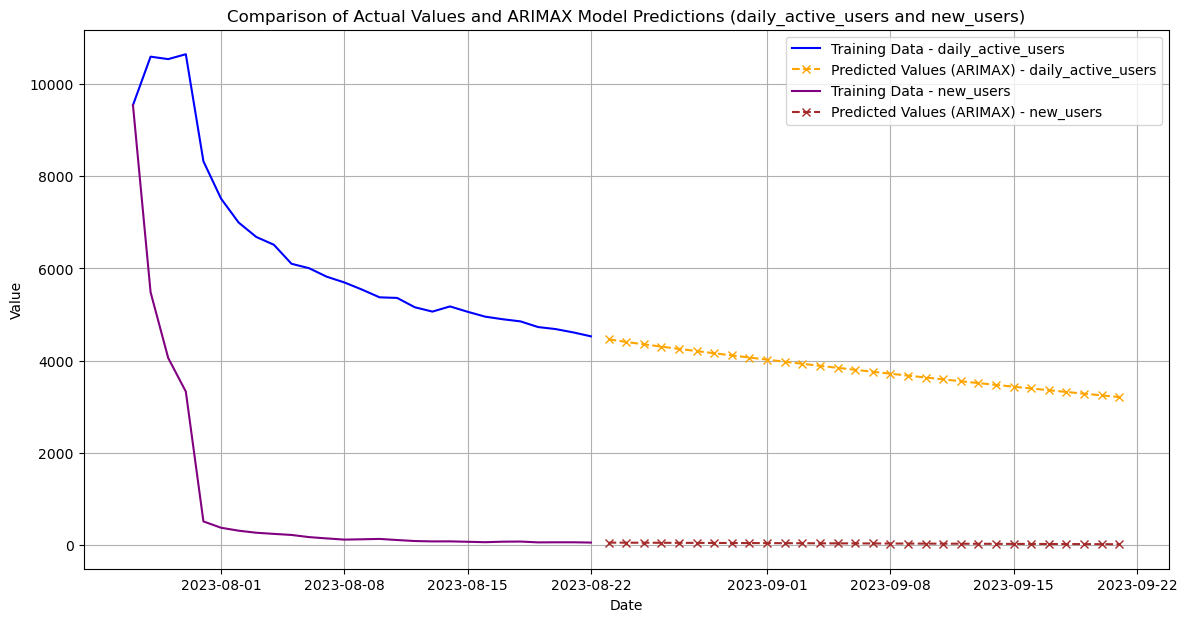

In [52]:
train_27_date = final_data["date"]
forecast_30_date = pd.date_range(start="2023-08-23", periods=30, freq='D')

# Plotting
plt.figure(figsize=(14, 7))

# Plot training data for daily_active_users
plt.plot(train_27_date, y, label='Training Data - daily_active_users', color='blue')

# Plot predicted values for daily_active_users
plt.plot(forecast_30_date, forecast_active_users, 
         label='Predicted Values (ARIMAX) - daily_active_users', color='orange', linestyle='--', marker='x')

# Plot training data for new_users
plt.plot(train_27_date, X, label='Training Data - new_users', color='purple')

# Plot predicted values for new_users
plt.plot(forecast_30_date, new_users_forecast, 
         label='Predicted Values (ARIMAX) - new_users', color='brown', linestyle='--', marker='x')

# Plot title and labels
plt.title("Comparison of Actual Values and ARIMAX Model Predictions (daily_active_users and new_users)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()
